In [1]:
#Static cirucit of long range CNOT gate for both odd and even number of qubits

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

def get_CNOT_circuit_static(num_qubit):
    qr=QuantumRegister(num_qubit)
    cr3=ClassicalRegister(num_qubit,name="cr3")
    qc=QuantumCircuit(qr,cr3)

    qc.h(0)
    
    mid_qubit_index=int((num_qubit-1)/2)
    for i in range(0,mid_qubit_index):
        qc.cx(i,i+1)
        qc.cx(i+1,i)
    for i in range(num_qubit-1-1,mid_qubit_index+1-1,-1):
        qc.cx(i+1,i)
        qc.cx(i,i+1)
        
    qc.cx(mid_qubit_index,mid_qubit_index+1)
    
    for i in range(mid_qubit_index-1,0-1,-1):
        qc.cx(i+1,i)
        qc.cx(i,i+1)
    for i in range(mid_qubit_index+1,num_qubit-1):
        qc.cx(i,i+1)
        qc.cx(i+1,i)

    qc.barrier()
    
    for i in range(num_qubit):
        qc.measure(qr[i],cr3[i])
    
    return qc

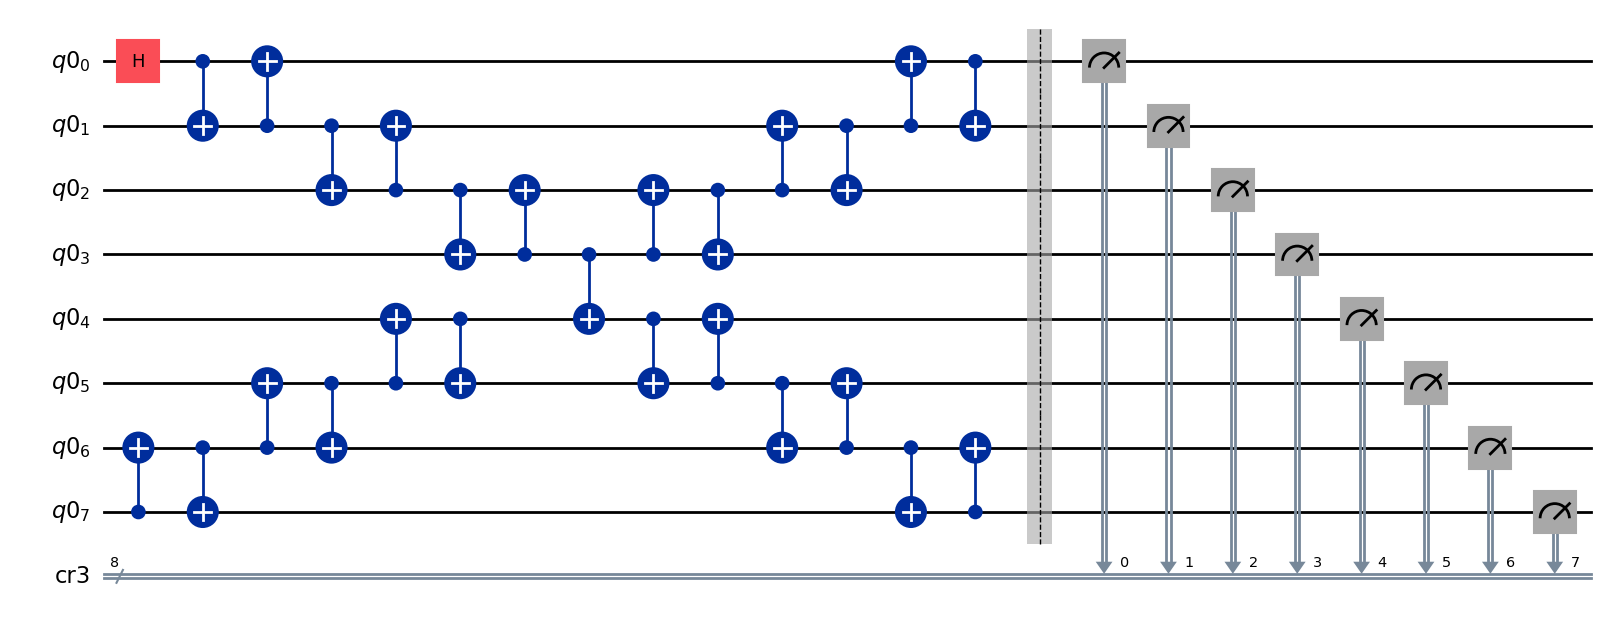

In [3]:
qc = get_CNOT_circuit_static(num_qubit=8)
qc.draw('mpl')

In [4]:
#Dynamic circuit of long range CNOT gate for odd number of qubits

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.classical import expr

def get_CNOT_circuit_dynamic_1(num_qubit):
    """
    (1) 1D chain of nearest neighbors
    (2) 0th qubit is the control, and the last qubit (num_qubit-1) is the target
    (3) The control qubit starts in the + state
    """
    num_ancilla = num_qubit - 2
    num_ancilla_pair = int(num_ancilla / 2)

    qr = QuantumRegister(num_qubit)
    cr1 = ClassicalRegister(num_ancilla_pair, name="cr1") # The parity-controlled X gate
    cr2 = ClassicalRegister(num_ancilla - num_ancilla_pair, name="cr2") # The parity-controlled Z gate
    cr3 = ClassicalRegister(2, name="cr3") # For the final measurements on the control and target qubits
    qc = QuantumCircuit(qr, cr1, cr2, cr3)

    # Initialize the control qubit
    qc.h(0)
    qc.barrier()

    # Entangle the contorl qubit and the first ancilla qubit
    qc.cx(0,1)

    # Create Bell pairs on ancilla qubits
    # The first ancilla qubit in index 1
    for i in range(num_ancilla_pair):
        qc.h(2+2*i)
        qc.cx(2+2*i, 2+2*i+1)

    # Prepare Bell pairs on staggered ancilla and data qubits
    for i in range(num_ancilla_pair+1):
        qc.cx(1+2*i, 1+2*i+1)
    for i in range(1, num_ancilla_pair+2):
        qc.h(2*i-1)

    # Measurement on alternating ancilla qubits starting with the first one
    # Keep track of the parity for eventual conditional Z gate
    for i in range(1, num_ancilla_pair+2):
        qc.measure(2*i - 1, cr2[i-1])
        if i == 1:
            parity_control = expr.lift(cr2[i-1])
        else:
            parity_control = expr.bit_xor(cr2[i-1], parity_control)

    # Measurement on staggered alternating ancilla qubits starting with the second
    # Keep track of the parity of eventual conditional X gate
    for i in range(num_ancilla_pair):
        qc.measure(2*i + 2, cr1[i])
        if i == 0:
            parity_target = expr.lift(cr1[i])
        else:
            parity_target = expr.bit_xor(cr1[i], parity_target)

    with qc.if_test(parity_control):
        qc.z(0)

    with qc.if_test(parity_target):
        qc.x(-1)

    # Final measurements on the control and target qubits
    qc.measure(0, cr3[0])
    qc.measure(-1, cr3[1])

    return qc


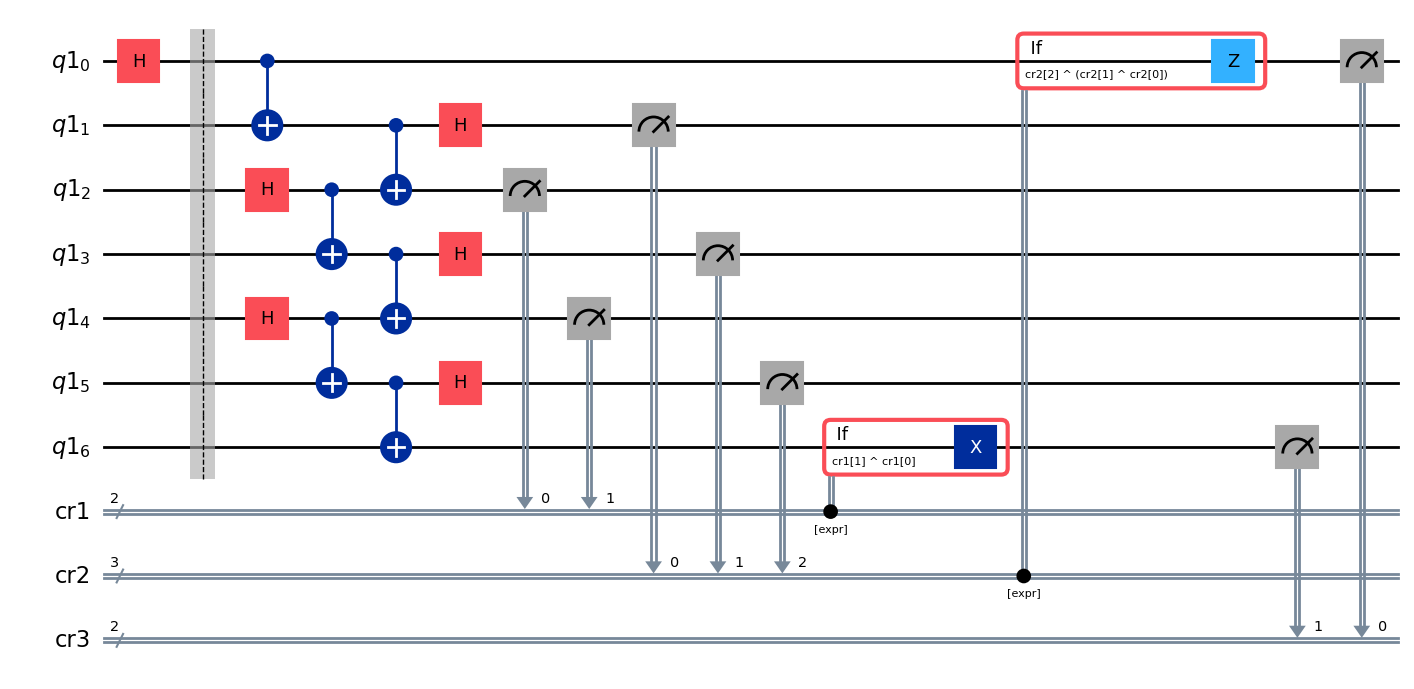

In [6]:
qc = get_CNOT_circuit_dynamic_1(num_qubit=7)
qc.draw(output='mpl')

In [7]:
#Dynamic circuit of long range CNOT gate using qubit-reuse in aersimulator

In [8]:
def get_CNOT_circuit_static_1(num_qubit):
    qr=QuantumRegister(num_qubit)
    cr3=ClassicalRegister(num_qubit,name="cr3")
    qc=QuantumCircuit(qr,cr3)

    qc.h(0)
    
    mid_qubit_index=int((num_qubit-1)/2)
    for i in range(0,mid_qubit_index):
        qc.cx(i,i+1)
        qc.cx(i+1,i)
    for i in range(num_qubit-1-1,mid_qubit_index+1-1,-1):
        qc.cx(i+1,i)
        qc.cx(i,i+1)
        
    qc.cx(mid_qubit_index,mid_qubit_index+1)
    
    for i in range(mid_qubit_index-1,0-1,-1):
        qc.cx(i+1,i)
        qc.cx(i,i+1)
    for i in range(mid_qubit_index+1,num_qubit-1):
        qc.cx(i,i+1)
        qc.cx(i+1,i)

    #qc.barrier()
    
    for i in range(num_qubit):
        qc.measure(qr[i],cr3[i])
    
    return qc

In [9]:
#creating dynamic circuit from a separate static circuit
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

def get_CNOT_circuit_dynamic_2(num_qubit):
    qc=get_CNOT_circuit_static_1(num_qubit)
    aer_sim = AerSimulator()
    pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1, init_method="qubit_reuse")
    transpiled_qc = pm.run(qc)
    return transpiled_qc

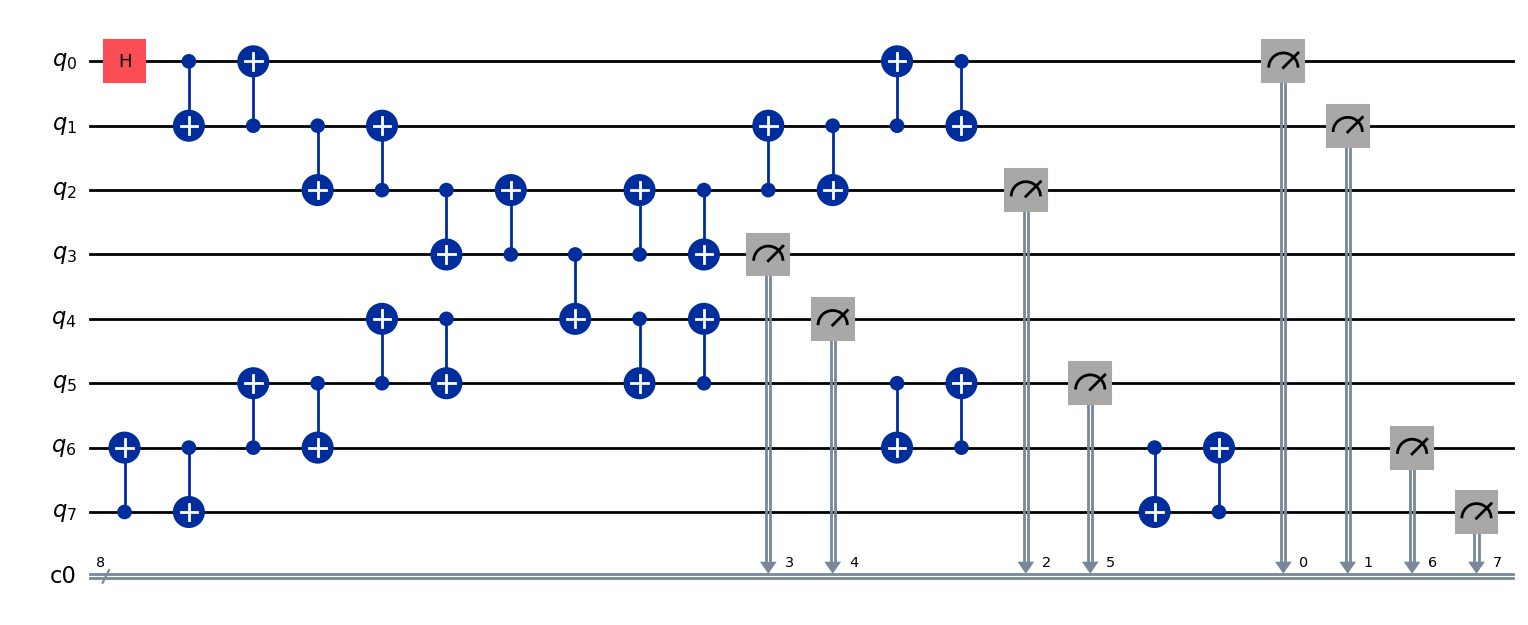

In [10]:
qc = get_CNOT_circuit_dynamic_2(num_qubit=8)
qc.draw("mpl")

In [11]:
#Creating list of circuits[Static_1, Dynamic1_1, Dynamic2_1, Static_1, Dynamic1_1, Dynamic2_1,...,Static_2, Dynamic1_2, Dynamic2_2, Static_2, Dynamic1_2, Dynamic2_2,...] i.e. some copies of each of them

min_qubit=17
max_num_qubit=19
copies=2

#qc_list_dynamic_1=[]
#qc_list_dynamic_2=[]
#qc_list_static=[]
#observables=[]

qc_list=[]
num_qubit_list=list(range(min_qubit,max_num_qubit+1,2))
for num_qubit in num_qubit_list:
    for i in range(copies):
        qc_list.append(get_CNOT_circuit_static(num_qubit))
        qc_list.append(get_CNOT_circuit_dynamic_1(num_qubit))
        qc_list.append(get_CNOT_circuit_dynamic_2(num_qubit))
print(num_qubit_list)

[17, 19]


In [12]:
#Ideal Simulation with AerSimulator
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
 
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1, basis_gates=['snapshot', 'store', 'measure', 'barrier', 'h', 'cx'], translation_method='translator')
qc_transpiled_list=[]

qc_transpiled_list_ideal = pm.run(qc_list)

In [13]:
sampler = Sampler(backend=aer_sim)
result_ideal = sampler.run(qc_transpiled_list_ideal).result()

In [14]:
print(result_ideal)
len(result_ideal)

PrimitiveResult([PubResult(data=DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=17>))), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=7>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=8>), cr3=BitArray(<shape=(), num_shots=1024, num_bits=2>))), PubResult(data=DataBin(c2=BitArray(<shape=(), num_shots=1024, num_bits=17>))), PubResult(data=DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=17>))), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=7>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=8>), cr3=BitArray(<shape=(), num_shots=1024, num_bits=2>))), PubResult(data=DataBin(c4=BitArray(<shape=(), num_shots=1024, num_bits=17>))), PubResult(data=DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=19>))), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=8>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=9>), cr3=BitArray(<shape=(), num_shots=1024, num_bits=2>))), PubResult(data=DataBin(c

12

In [15]:
# For getting list of ideal counts (argument required for Fidelity)
counts_list_ideal=[]
k=0
for i in range(len(num_qubit_list)):  
    for j in range(copies):
        data_static = result_ideal[(3*i*copies)+(3*j)].data    
        data_dynamic_1 = result_ideal[(3*i*copies)+((3*j)+1)].data 
        data_dynamic_2 = result_ideal[(3*i*copies)+((3*j)+2)].data

        print(data_static)
        print(data_dynamic_1)
        print(data_dynamic_2)
        
        counts_static=data_static.cr3.get_counts()
        counts_dynamic_1=data_dynamic_1.cr3.get_counts()
        
        # Replacing 'cr3' with the appropriate attribute if needed
        dynamic_2_attr_name = f'c{2*(k+1)}'
        if hasattr(data_dynamic_2, dynamic_2_attr_name):
            counts_dynamic_2 = getattr(data_dynamic_2, dynamic_2_attr_name).get_counts()
        else:
            raise AttributeError(f"{dynamic_2_attr_name} not found in data_dynamic_2")
        
        counts_list_ideal.append(counts_static)
        counts_list_ideal.append(counts_dynamic_1)
        counts_list_ideal.append(counts_dynamic_2)
        k=k+1

DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=7>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=8>), cr3=BitArray(<shape=(), num_shots=1024, num_bits=2>))
DataBin(c2=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=7>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=8>), cr3=BitArray(<shape=(), num_shots=1024, num_bits=2>))
DataBin(c4=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=19>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=8>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=9>), cr3=BitArray(<shape=(), num_shots=1024, num_bits=2>))
DataBin(c6=BitArray(<shape=(), num_shots=1024, num_bits=19>))
DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=19>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_

In [16]:
# Simulation of real hardware to get result_real
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
 
 
service = QiskitRuntimeService()
 
# Specify a system to use for the noise model
real_backend = service.backend("ibm_brisbane")
aer = AerSimulator.from_backend(real_backend)
 
# Run the sampler job locally using AerSimulator.
pm = generate_preset_pass_manager(backend=aer, optimization_level=1)
qc_transpiled_list_real = pm.run(qc_list)
sampler = Sampler(backend=aer)
result_brisbane = sampler.run(qc_transpiled_list_real).result()

In [17]:
# Simulation of real hardware to get result_real
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
 
 
service = QiskitRuntimeService()
 
# Specify a system to use for the noise model
real_backend = service.backend("ibm_sherbrooke")
aer = AerSimulator.from_backend(real_backend)
 
# Run the sampler job locally using AerSimulator.
pm = generate_preset_pass_manager(backend=aer, optimization_level=1)
qc_transpiled_list_real = pm.run(qc_list)
sampler = Sampler(backend=aer)
result_sherbrooke = sampler.run(qc_transpiled_list_real).result()

In [18]:
# Simulation of real hardware to get result_real
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
 
 
service = QiskitRuntimeService()
 
# Specify a system to use for the noise model
real_backend = service.backend("ibm_osaka")
aer = AerSimulator.from_backend(real_backend)
 
# Run the sampler job locally using AerSimulator.
pm = generate_preset_pass_manager(backend=aer, optimization_level=1)
qc_transpiled_list_real = pm.run(qc_list)                               
sampler = Sampler(backend=aer)
result_osaka = sampler.run(qc_transpiled_list_real).result()

In [19]:
# Simulation of real hardware to get result_real
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
 
 
service = QiskitRuntimeService()
 
# Specify a system to use for the noise model
real_backend = service.backend("ibm_kyoto")
aer = AerSimulator.from_backend(real_backend)
 
# Run the sampler job locally using AerSimulator.
pm = generate_preset_pass_manager(backend=aer, optimization_level=1)
qc_transpiled_list_real = pm.run(qc_list)                                
sampler = Sampler(backend=aer)
result_kyoto = sampler.run(qc_transpiled_list_real).result()

In [20]:
#get list counts_list_brisbane, counts_list_sherbrooke, counts_list_osaka, counts_list_kyoto (argument required for Fidelity)
counts_list_brisbane=[]
counts_list_sherbrooke=[]
counts_list_osaka=[]
counts_list_kyoto=[]
k=0
for i in range(len(num_qubit_list)):  
    for j in range(copies):
        data_static = result_brisbane[(3*i*copies)+(3*j)].data
        data_dynamic_1 = result_brisbane[(3*i*copies)+((3*j)+1)].data
        data_dynamic_2 = result_brisbane[(3*i*copies)+((3*j)+2)].data
        counts_static=data_static.cr3.get_counts()
        counts_dynamic_1=data_dynamic_1.cr3.get_counts()
        dynamic_2_attr_name = f'c{2*(k+1)}'
        if hasattr(data_dynamic_2, dynamic_2_attr_name):
            counts_dynamic_2 = getattr(data_dynamic_2, dynamic_2_attr_name).get_counts()
        else:
            raise AttributeError(f"{dynamic_2_attr_name} not found in data_dynamic_2")
        counts_list_brisbane.append(counts_static)
        counts_list_brisbane.append(counts_dynamic_1)
        counts_list_brisbane.append(counts_dynamic_2)

        data_static = result_sherbrooke[(3*i*copies)+(3*j)].data
        data_dynamic_1 = result_sherbrooke[(3*i*copies)+((3*j)+1)].data
        data_dynamic_2 = result_sherbrooke[(3*i*copies)+((3*j)+2)].data
        counts_static=data_static.cr3.get_counts()
        counts_dynamic_1=data_dynamic_1.cr3.get_counts()
        dynamic_2_attr_name = f'c{2*(k+1)}'
        if hasattr(data_dynamic_2, dynamic_2_attr_name):
            counts_dynamic_2 = getattr(data_dynamic_2, dynamic_2_attr_name).get_counts()
        else:
            raise AttributeError(f"{dynamic_2_attr_name} not found in data_dynamic_2")
        counts_list_sherbrooke.append(counts_static)
        counts_list_sherbrooke.append(counts_dynamic_1)
        counts_list_sherbrooke.append(counts_dynamic_2)

        data_static = result_osaka[(3*i*copies)+(3*j)].data
        data_dynamic_1 = result_osaka[(3*i*copies)+((3*j)+1)].data
        data_dynamic_2 = result_osaka[(3*i*copies)+((3*j)+2)].data
        counts_static=data_static.cr3.get_counts()
        counts_dynamic_1=data_dynamic_1.cr3.get_counts()
        dynamic_2_attr_name = f'c{2*(k+1)}'
        if hasattr(data_dynamic_2, dynamic_2_attr_name):
            counts_dynamic_2 = getattr(data_dynamic_2, dynamic_2_attr_name).get_counts()
        else:
            raise AttributeError(f"{dynamic_2_attr_name} not found in data_dynamic_2")
        counts_list_osaka.append(counts_static)
        counts_list_osaka.append(counts_dynamic_1)
        counts_list_osaka.append(counts_dynamic_2)

        data_static = result_kyoto[(3*i*copies)+(3*j)].data
        data_dynamic_1 = result_kyoto[(3*i*copies)+((3*j)+1)].data
        data_dynamic_2 = result_kyoto[(3*i*copies)+((3*j)+2)].data
        counts_static=data_static.cr3.get_counts()
        counts_dynamic_1=data_dynamic_1.cr3.get_counts()
        dynamic_2_attr_name = f'c{2*(k+1)}'
        if hasattr(data_dynamic_2, dynamic_2_attr_name):
            counts_dynamic_2 = getattr(data_dynamic_2, dynamic_2_attr_name).get_counts()
        else:
            raise AttributeError(f"{dynamic_2_attr_name} not found in data_dynamic_2")
        counts_list_kyoto.append(counts_static)
        counts_list_kyoto.append(counts_dynamic_1)
        counts_list_kyoto.append(counts_dynamic_2)
        k=k+1

In [21]:
#Calculation of lists of Fidelity mean and std deviation of all 4 hardware simulation
import statistics
from qiskit.quantum_info.analysis import hellinger_fidelity
# We will create 4 lists of Fidelities, for storing mean, std deviation of Fidelity, of copies of a circuit for fixed no of logical qubits
# For GHZ state analysis: index 0 of these lists store informationn of GHZ state having 3 qubits, index 1 for 4 qubits and so on 
Fidelity_mean_static_brisbane=[]
Fidelity_mean_dynamic_1_brisbane=[]
Fidelity_mean_dynamic_2_brisbane=[]
Fidelity_std_static_brisbane=[]
Fidelity_std_dynamic_1_brisbane=[]
Fidelity_std_dynamic_2_brisbane=[]
Fidelity_copies_static_brisbane=[]
Fidelity_copies_dynamic_1_brisbane=[]
Fidelity_copies_dynamic_2_brisbane=[]

Fidelity_mean_static_sherbrooke=[]
Fidelity_mean_dynamic_1_sherbrooke=[]
Fidelity_mean_dynamic_2_sherbrooke=[]
Fidelity_std_static_sherbrooke=[]
Fidelity_std_dynamic_1_sherbrooke=[]
Fidelity_std_dynamic_2_sherbrooke=[]
Fidelity_copies_static_sherbrooke=[]
Fidelity_copies_dynamic_1_sherbrooke=[]
Fidelity_copies_dynamic_2_sherbrooke=[]

Fidelity_mean_static_osaka=[]
Fidelity_mean_dynamic_1_osaka=[]
Fidelity_mean_dynamic_2_osaka=[]
Fidelity_std_static_osaka=[]
Fidelity_std_dynamic_1_osaka=[]
Fidelity_std_dynamic_2_osaka=[]
Fidelity_copies_static_osaka=[]
Fidelity_copies_dynamic_1_osaka=[]
Fidelity_copies_dynamic_2_osaka=[]

Fidelity_mean_static_kyoto=[]
Fidelity_mean_dynamic_1_kyoto=[]
Fidelity_mean_dynamic_2_kyoto=[]
Fidelity_std_static_kyoto=[]
Fidelity_std_dynamic_1_kyoto=[]
Fidelity_std_dynamic_2_kyoto=[]
Fidelity_copies_static_kyoto=[]
Fidelity_copies_dynamic_1_kyoto=[]
Fidelity_copies_dynamic_2_kyoto=[]
for i in range(len(num_qubit_list)):
    
    for j in range(copies):
        
        Fidelity_static= hellinger_fidelity(counts_list_ideal[(3*i*copies)+(3*j)], counts_list_brisbane[(3*i*copies)+(3*j)])
        Fidelity_dynamic_1=hellinger_fidelity(counts_list_ideal[(3*i*copies)+((3*j)+1)], counts_list_brisbane[(3*i*copies)+((3*j)+1)])
        Fidelity_dynamic_2=hellinger_fidelity(counts_list_ideal[(3*i*copies)+((3*j)+2)], counts_list_brisbane[(3*i*copies)+((3*j)+2)])
        Fidelity_copies_static_brisbane.append(Fidelity_static)
        Fidelity_copies_dynamic_1_brisbane.append(Fidelity_dynamic_1)
        Fidelity_copies_dynamic_2_brisbane.append(Fidelity_dynamic_2)

        Fidelity_static= hellinger_fidelity(counts_list_ideal[(3*i*copies)+(3*j)], counts_list_sherbrooke[(3*i*copies)+(3*j)])
        Fidelity_dynamic_1=hellinger_fidelity(counts_list_ideal[(3*i*copies)+((3*j)+1)], counts_list_sherbrooke[(3*i*copies)+((3*j)+1)])
        Fidelity_dynamic_2=hellinger_fidelity(counts_list_ideal[(3*i*copies)+((3*j)+2)], counts_list_sherbrooke[(3*i*copies)+((3*j)+2)])
        Fidelity_copies_static_sherbrooke.append(Fidelity_static)
        Fidelity_copies_dynamic_1_sherbrooke.append(Fidelity_dynamic_1)
        Fidelity_copies_dynamic_2_sherbrooke.append(Fidelity_dynamic_2)

        Fidelity_static= hellinger_fidelity(counts_list_ideal[(3*i*copies)+(3*j)], counts_list_osaka[(3*i*copies)+(3*j)])
        Fidelity_dynamic_1=hellinger_fidelity(counts_list_ideal[(3*i*copies)+((3*j)+1)], counts_list_osaka[(3*i*copies)+((3*j)+1)])
        Fidelity_dynamic_2=hellinger_fidelity(counts_list_ideal[(3*i*copies)+((3*j)+2)], counts_list_osaka[(3*i*copies)+((3*j)+2)])
        Fidelity_copies_static_osaka.append(Fidelity_static)
        Fidelity_copies_dynamic_1_osaka.append(Fidelity_dynamic_1)
        Fidelity_copies_dynamic_2_osaka.append(Fidelity_dynamic_2)

        Fidelity_static= hellinger_fidelity(counts_list_ideal[(3*i*copies)+(3*j)], counts_list_kyoto[(3*i*copies)+(3*j)])
        Fidelity_dynamic_1=hellinger_fidelity(counts_list_ideal[(3*i*copies)+((3*j)+1)], counts_list_kyoto[(3*i*copies)+((3*j)+1)])
        Fidelity_dynamic_2=hellinger_fidelity(counts_list_ideal[(3*i*copies)+((3*j)+2)], counts_list_kyoto[(3*i*copies)+((3*j)+2)])
        Fidelity_copies_static_kyoto.append(Fidelity_static)
        Fidelity_copies_dynamic_1_kyoto.append(Fidelity_dynamic_1)
        Fidelity_copies_dynamic_2_kyoto.append(Fidelity_dynamic_2)

    
    Fidelity_mean_static_brisbane.append(statistics.mean(Fidelity_copies_static_brisbane))
    Fidelity_mean_dynamic_1_brisbane.append(statistics.mean(Fidelity_copies_dynamic_1_brisbane))
    Fidelity_mean_dynamic_2_brisbane.append(statistics.mean(Fidelity_copies_dynamic_2_brisbane))
    Fidelity_std_static_brisbane.append(statistics.stdev(Fidelity_copies_static_brisbane))
    Fidelity_std_dynamic_1_brisbane.append(statistics.stdev(Fidelity_copies_dynamic_1_brisbane))
    Fidelity_std_dynamic_2_brisbane.append(statistics.stdev(Fidelity_copies_dynamic_2_brisbane))
    Fidelity_copies_static_brisbane.clear()
    Fidelity_copies_dynamic_1_brisbane.clear()
    Fidelity_copies_dynamic_2_brisbane.clear()

    Fidelity_mean_static_sherbrooke.append(statistics.mean(Fidelity_copies_static_sherbrooke))
    Fidelity_mean_dynamic_1_sherbrooke.append(statistics.mean(Fidelity_copies_dynamic_1_sherbrooke))
    Fidelity_mean_dynamic_2_sherbrooke.append(statistics.mean(Fidelity_copies_dynamic_2_sherbrooke))
    Fidelity_std_static_sherbrooke.append(statistics.stdev(Fidelity_copies_static_sherbrooke))
    Fidelity_std_dynamic_1_sherbrooke.append(statistics.stdev(Fidelity_copies_dynamic_1_sherbrooke))
    Fidelity_std_dynamic_2_sherbrooke.append(statistics.stdev(Fidelity_copies_dynamic_2_sherbrooke))
    Fidelity_copies_static_sherbrooke.clear()
    Fidelity_copies_dynamic_1_sherbrooke.clear()
    Fidelity_copies_dynamic_2_sherbrooke.clear()

    Fidelity_mean_static_osaka.append(statistics.mean(Fidelity_copies_static_osaka))
    Fidelity_mean_dynamic_1_osaka.append(statistics.mean(Fidelity_copies_dynamic_1_osaka))
    Fidelity_mean_dynamic_2_osaka.append(statistics.mean(Fidelity_copies_dynamic_2_osaka))
    Fidelity_std_static_osaka.append(statistics.stdev(Fidelity_copies_static_osaka))
    Fidelity_std_dynamic_1_osaka.append(statistics.stdev(Fidelity_copies_dynamic_1_osaka))
    Fidelity_std_dynamic_2_osaka.append(statistics.stdev(Fidelity_copies_dynamic_2_osaka))
    Fidelity_copies_static_osaka.clear()
    Fidelity_copies_dynamic_1_osaka.clear()
    Fidelity_copies_dynamic_2_osaka.clear()

    Fidelity_mean_static_kyoto.append(statistics.mean(Fidelity_copies_static_kyoto))
    Fidelity_mean_dynamic_1_kyoto.append(statistics.mean(Fidelity_copies_dynamic_1_kyoto))
    Fidelity_mean_dynamic_2_kyoto.append(statistics.mean(Fidelity_copies_dynamic_2_kyoto))
    Fidelity_std_static_kyoto.append(statistics.stdev(Fidelity_copies_static_kyoto))
    Fidelity_std_dynamic_1_kyoto.append(statistics.stdev(Fidelity_copies_dynamic_1_kyoto))
    Fidelity_std_dynamic_2_kyoto.append(statistics.stdev(Fidelity_copies_dynamic_2_kyoto))
    Fidelity_copies_static_kyoto.clear()
    Fidelity_copies_dynamic_1_kyoto.clear()
    Fidelity_copies_dynamic_2_kyoto.clear()

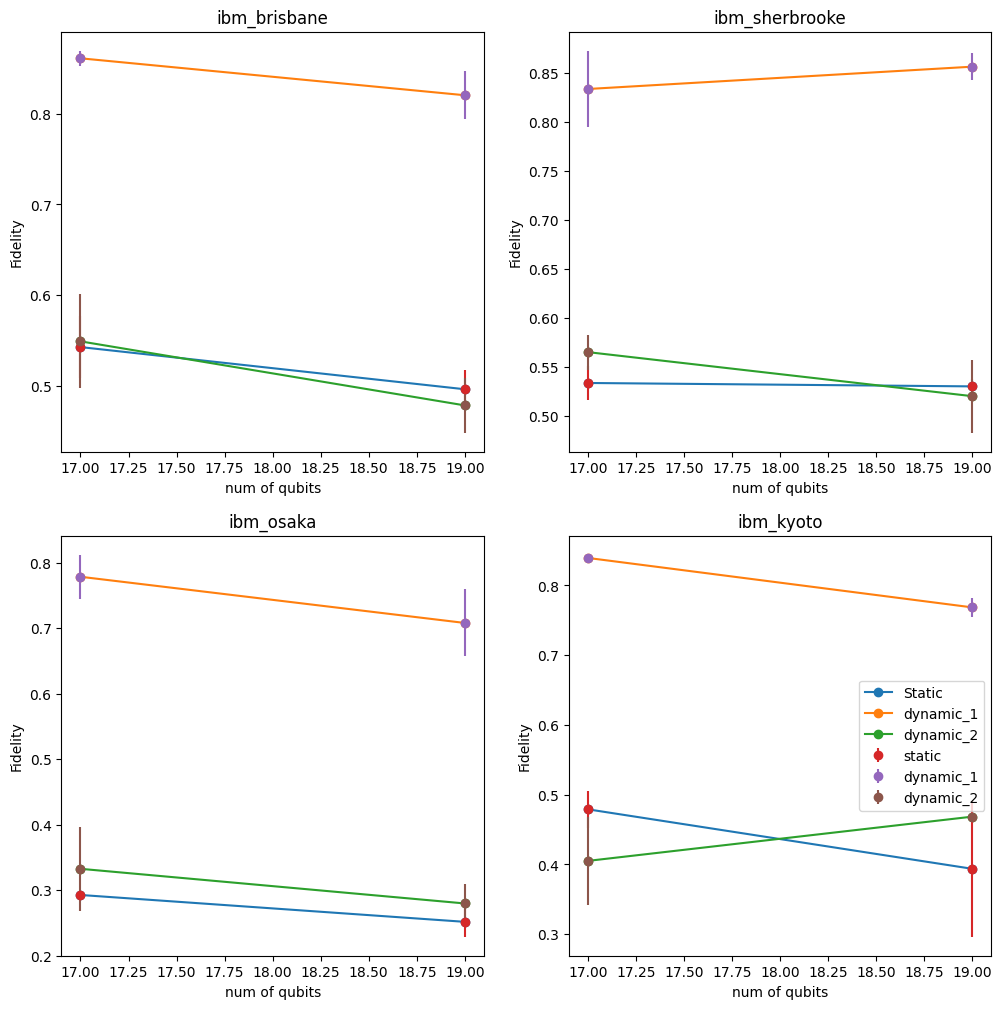

In [22]:
# Graph plotting
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
#figure(figsize=(16,12), dpi=180)
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12,12))

# Create  data.
ax1.set_xlabel('num of qubits')
ax1.set_ylabel('Fidelity')
ax1.set_title('ibm_brisbane')
x1 = num_qubit_list
y1_static = Fidelity_mean_static_brisbane
y1_dynamic_1 = Fidelity_mean_dynamic_1_brisbane
y1_dynamic_2 = Fidelity_mean_dynamic_2_brisbane
y_error_static =Fidelity_std_static_brisbane
y_error_dynamic_1 =Fidelity_std_dynamic_1_brisbane
y_error_dynamic_2 =Fidelity_std_dynamic_2_brisbane
ax1.plot(x1, y1_static, 'o-',label='Static')
ax1.plot(x1, y1_dynamic_1, 'o-',label='dynamic_1')
ax1.plot(x1, y1_dynamic_2, 'o-',label='dynamic_2')
ax1.errorbar(x1, y1_static,
			yerr = y_error_static, label='static',
			fmt ='o')
ax1.errorbar(x1, y1_dynamic_1,
			yerr = y_error_dynamic_1, label='dynamic_1',
			fmt ='o')
ax1.errorbar(x1, y1_dynamic_2,
			yerr = y_error_dynamic_2, label='dynamic_2',
			fmt ='o')

ax2.set_xlabel('num of qubits')
ax2.set_ylabel('Fidelity')
ax2.set_title('ibm_sherbrooke')
x2 = num_qubit_list
y2_static = Fidelity_mean_static_sherbrooke
y2_dynamic_1 = Fidelity_mean_dynamic_1_sherbrooke
y2_dynamic_2 = Fidelity_mean_dynamic_2_sherbrooke
y_error_static =Fidelity_std_static_sherbrooke
y_error_dynamic_1 =Fidelity_std_dynamic_1_sherbrooke
y_error_dynamic_2 =Fidelity_std_dynamic_2_sherbrooke
ax2.plot(x2, y2_static, 'o-',label='Static')
ax2.plot(x2, y2_dynamic_1, 'o-',label='dynamic_1')
ax2.plot(x2, y2_dynamic_2, 'o-',label='dynamic_2')
ax2.errorbar(x2, y2_static,
			yerr = y_error_static, label='static',
			fmt ='o')
ax2.errorbar(x2, y2_dynamic_1,
			yerr = y_error_dynamic_1, label='dynamic_1',
			fmt ='o')
ax2.errorbar(x2, y2_dynamic_2,
			yerr = y_error_dynamic_2, label='dynamic_2',
			fmt ='o')

ax3.set_xlabel('num of qubits')
ax3.set_ylabel('Fidelity')
ax3.set_title('ibm_osaka')
x3 = num_qubit_list
y3_static = Fidelity_mean_static_osaka
y3_dynamic_1 = Fidelity_mean_dynamic_1_osaka
y3_dynamic_2 = Fidelity_mean_dynamic_2_osaka
y_error_static =Fidelity_std_static_osaka
y_error_dynamic_1 =Fidelity_std_dynamic_1_osaka
y_error_dynamic_2 =Fidelity_std_dynamic_2_osaka
ax3.plot(x3, y3_static, 'o-',label='Static')
ax3.plot(x3, y3_dynamic_1, 'o-',label='dynamic_1')
ax3.plot(x3, y3_dynamic_2, 'o-',label='dynamic_2')
ax3.errorbar(x3, y3_static,
			yerr = y_error_static, label='static',
			fmt ='o')
ax3.errorbar(x3, y3_dynamic_1,
			yerr = y_error_dynamic_1, label='dynamic_1',
			fmt ='o')
ax3.errorbar(x3, y3_dynamic_2,
			yerr = y_error_dynamic_2, label='dynamic_2',
			fmt ='o')

ax4.set_xlabel('num of qubits')
ax4.set_ylabel('Fidelity')
ax4.set_title('ibm_kyoto')
x4 = num_qubit_list
y4_static = Fidelity_mean_static_kyoto
y4_dynamic_1 = Fidelity_mean_dynamic_1_kyoto
y4_dynamic_2 = Fidelity_mean_dynamic_2_kyoto
y_error_static =Fidelity_std_static_kyoto
y_error_dynamic_1 =Fidelity_std_dynamic_1_kyoto
y_error_dynamic_2 =Fidelity_std_dynamic_2_kyoto
ax4.plot(x4, y4_static, 'o-',label='Static')
ax4.plot(x4, y4_dynamic_1, 'o-',label='dynamic_1')
ax4.plot(x4, y4_dynamic_2, 'o-',label='dynamic_2')
ax4.errorbar(x4, y4_static,
			yerr = y_error_static, label='static',
			fmt ='o')
ax4.errorbar(x4, y4_dynamic_1,
			yerr = y_error_dynamic_1, label='dynamic_1',
			fmt ='o')
ax4.errorbar(x4, y4_dynamic_2,
			yerr = y_error_dynamic_2, label='dynamic_2',
			fmt ='o')


plt.legend()
plt.show()